In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df = pd.read_csv("data/data_train_combined.csv")
train_df = train_df.sample(frac=0.1, random_state=42)
label_mapping = {"hate": 1, "nothate": 0}
train_df["label"] = train_df["label"].map(label_mapping).astype(int)

In [ ]:
val_df = pd.read_csv("data/data_val_combined.csv")
val_df["label"] = val_df["label"].map(label_mapping).astype(int)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.config.hidden_dropout_prob = 0.2
model.config.attention_probs_dropout_prob = 0.2

text = "Hate Speech"
encoded_input = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
output = model(**encoded_input)
print("Output Completed!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output Completed!


In [ ]:
train_encodings = tokenizer(
    train_df["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

In [ ]:
train_labels = torch.tensor(train_df["label"].values, dtype=torch.long)

torch.save({"input_ids": train_encodings["input_ids"],
            "attention_mask": train_encodings["attention_mask"],
            "labels": train_labels}, "train_tokenized.pth")

print("Tokenization Completed!")

Tokenization Completed!


In [ ]:
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels) 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("DataLoader Created Successfully!")

DataLoader Created Successfully!


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

num_training_steps = len(train_loader) * 5
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=int(num_training_steps * 0.1),
    num_training_steps=num_training_steps
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model Moved to: {device}")

model.train()
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

Model Moved to: cuda


  0%|          | 0/147 [00:00<?, ?it/s]<ipython-input-12-77a8d2d0c1f0>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx])
Epoch 5: 100%|██████████| 147/147 [00:46<00:00,  3.18it/s, loss=0.219]


<ipython-input-12-77a8d2d0c1f0>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx])


Validation Accuracy: 0.7327
Hate Speech - Precision: 0.7557, Recall: 0.7576, F1-score: 0.7567
Non-Hate Speech - Precision: 0.7046, Recall: 0.7024, F1-score: 0.7035


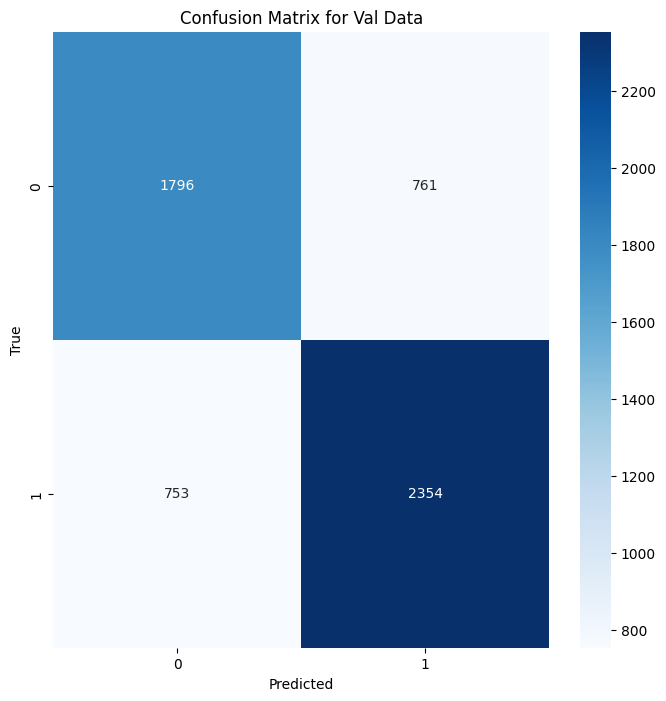

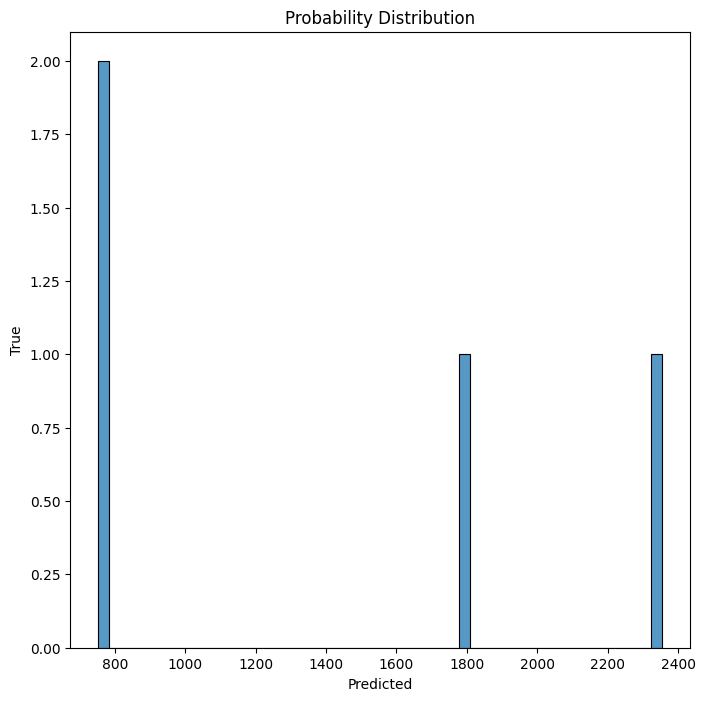

Training Complete!
Model Saved Successfully!


In [ ]:
val_encodings = tokenizer(
    val_df["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

val_labels = torch.tensor(val_df["label"].values, dtype=torch.long)
val_dataset = HateSpeechDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model.eval()
val_preds, val_labels_list = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels_list.extend(batch["labels"].cpu().numpy())

val_acc = accuracy_score(val_labels_list, val_preds)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels_list, val_preds, average=None)
print(f"Validation Accuracy: {val_acc:.4f}")

print(f"Hate Speech - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1-score: {f1[1]:.4f}")
print(f"Non-Hate Speech - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1-score: {f1[0]:.4f}")
cm = confusion_matrix(val_labels_list, val_preds)
plt.figure(figsize=[8, 8])
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Val Data")
plt.show()

plt.figure(figsize=[8, 8])
sns.histplot(cm.ravel(), bins=50)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Probability Distribution")
plt.show()
model.train()
print("Training Complete!")
model.save_pretrained("saved_distilbert_model")
tokenizer.save_pretrained("saved_distilbert_model")

print("Model Saved Successfully!")

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("saved_distilbert_model")
tokenizer = DistilBertTokenizer.from_pretrained("saved_distilbert_model")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Pretrained Model loaded complete")

Pretrained Model loaded complete


In [ ]:
df=pd.read_csv("data/data_test_combined.csv")
df=df.dropna()
print("Data loaded complete")

Data loaded complete


In [ ]:
df["label"] = df["label"].map({"hate": 1, "nothate": 0})
encodings = tokenizer(
    df["text"].tolist(),
    truncation=True,
    max_length=512,
    padding="max_length",
    return_tensors="pt",
)
input = {key: value.to(device) for key, value in encodings.items()}
print("Tokenization success")

Tokenization success


Test Accuracy: 0.7241
Hate Speech - Precision: 0.7583, Recall: 0.7650, F1-score: 0.7616
Non-Hate Speech - Precision: 0.6767, Recall: 0.6684, F1-score: 0.6725


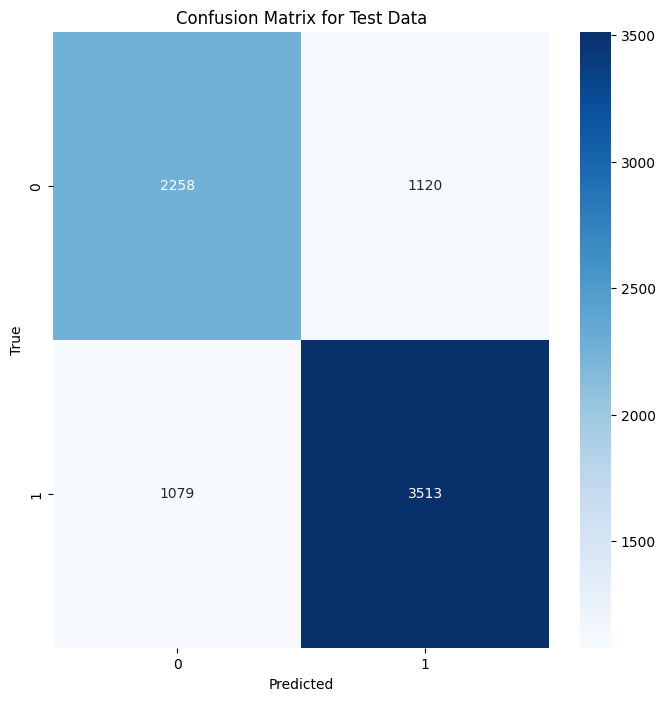

In [ ]:
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_ids = input["input_ids"].to(device)
attention_mask = input["attention_mask"].to(device)
test_labels = torch.tensor(df["label"].values, dtype=torch.long).to(device)

dataset = TensorDataset(input_ids, attention_mask, test_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

predictions_list = []
labels_list = []

with torch.no_grad():
    for batch in dataloader:
        batch_input_ids, batch_attention_mask, batch_labels = batch
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions_list.extend(preds.cpu().numpy())
        labels_list.extend(batch_labels.cpu().numpy())

test_acc = accuracy_score(labels_list, predictions_list)
precision, recall, f1, _ = precision_recall_fscore_support(labels_list, predictions_list, average=None)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Hate Speech - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1-score: {f1[1]:.4f}")
print(f"Non-Hate Speech - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1-score: {f1[0]:.4f}")

cm = confusion_matrix(labels_list, predictions_list)
plt.figure(figsize=[8, 8])
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Test Data")
plt.show()

In [ ]:
df["predictions"] = predictions_list
df["predictions"] = df["predictions"].map({1: "This is hate speech", 0: "This is not hate speech"})

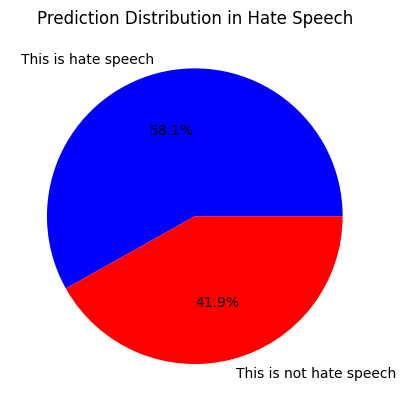

In [ ]:
df["predictions"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["blue", "red", "yellow"])
plt.ylabel("")
plt.title("Prediction Distribution in Hate Speech")
plt.show()